

1.   Linear Regression - Task 02


*   Changing the impact of outliers on Linear Regression using various schemes





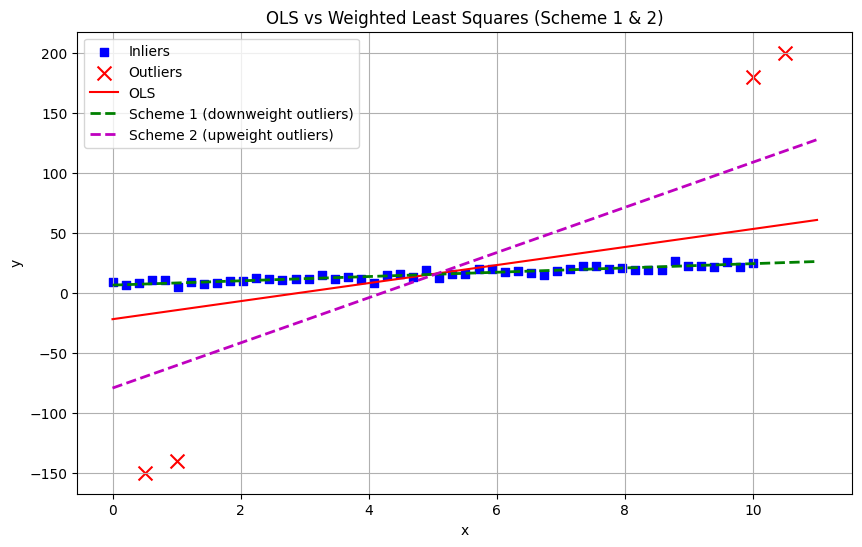

In [ ]:
# Weighted Least Squares Demo: OLS vs Scheme 1 vs Scheme 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -------------------------
# Generate synthetic data
# -------------------------
np.random.seed(0)

# True line: y = 2x + 5
X_inliers = np.linspace(0, 10, 50)
y_inliers = 2*X_inliers + 5 + np.random.normal(0, 2, size=X_inliers.shape)

# Outliers: extreme values
X_outliers = np.array([0.5, 1.0, 10.0, 10.5])
y_outliers = np.array([-150, -140, 180, 200])

# Combine
X = np.concatenate([X_inliers, X_outliers])
y = np.concatenate([y_inliers, y_outliers])
X = X.reshape(-1,1)

# Identify outlier indices (last few points)
outlier_mask = np.zeros(len(y), dtype=bool)
outlier_mask[-len(X_outliers):] = True

# -------------------------
# 1. Ordinary Least Squares
# -------------------------
ols = LinearRegression().fit(X, y)
y_pred_ols = ols.predict(X)

# -------------------------
# 2. Weighted Least Squares - Scheme 1
# (downweight outliers)
# -------------------------
weights_scheme1 = np.where(outlier_mask, 0.01, 1.0)
ols_w1 = LinearRegression().fit(X, y, sample_weight=weights_scheme1)
y_pred_w1 = ols_w1.predict(X)

# -------------------------
# 3. Weighted Least Squares - Scheme 2
# (upweight outliers)
# -------------------------
weights_scheme2 = np.where(outlier_mask, 5.0, 1.0)
ols_w2 = LinearRegression().fit(X, y, sample_weight=weights_scheme2)
y_pred_w2 = ols_w2.predict(X)

# -------------------------
# Visualization
# -------------------------
plt.figure(figsize=(10,6))
plt.scatter(X_inliers, y_inliers, c='blue', marker='s', label='Inliers')
plt.scatter(X_outliers, y_outliers, c='red', marker='x', s=100, label='Outliers')

# Fitted lines
x_line = np.linspace(0, 11, 100).reshape(-1,1)
plt.plot(x_line, ols.predict(x_line), 'r-', label='OLS')
plt.plot(x_line, ols_w1.predict(x_line), 'g--', linewidth=2, label='Scheme 1 (downweight outliers)')
plt.plot(x_line, ols_w2.predict(x_line), 'm--', linewidth=2, label='Scheme 2 (upweight outliers)')

plt.xlabel("x")
plt.ylabel("y")
plt.title("OLS vs Weighted Least Squares (Scheme 1 & 2)")
plt.legend()
plt.grid(True)
plt.show()




1.   Linear Regression - Task 05


*    LASSO or group LASSO in brain image analysis







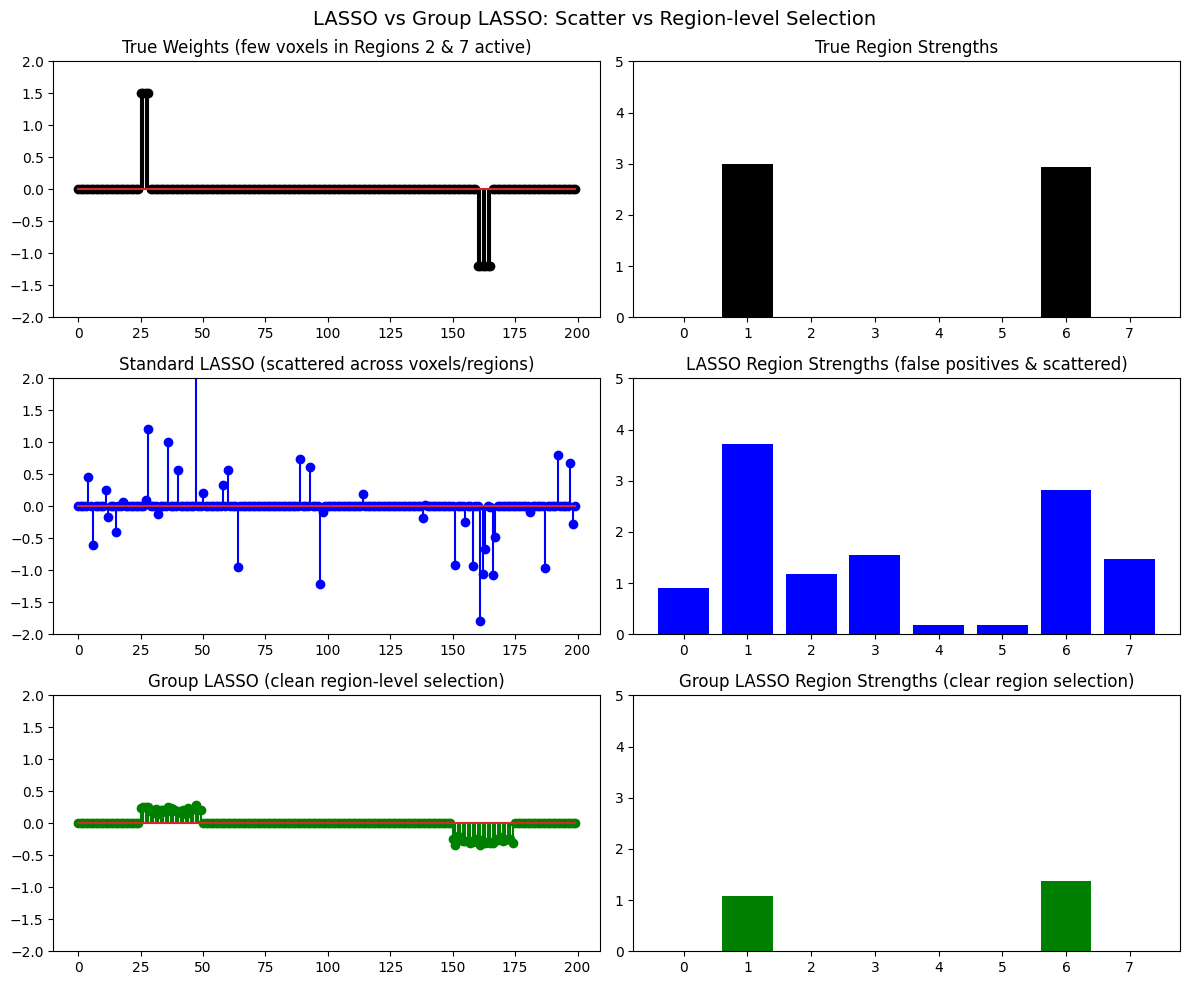

In [ ]:
# ======================================
# LASSO vs Group LASSO (fMRI-style demo)
# Google Colab ready
# ======================================

!pip install group-lasso matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from group_lasso import GroupLasso

# -------------------------
# Simulated fMRI-like data
# -------------------------
np.random.seed(2025)

N = 80            # number of subjects
G = 8             # number of brain regions
voxels_per_group = 25
D = G * voxels_per_group  # total voxels

# True weights: only a few voxels active in regions 2 and 7
true_w = np.zeros(D)
true_w[voxels_per_group:voxels_per_group+4] = 1.5       # 4 voxels in region 2
true_w[6*voxels_per_group+10 : 6*voxels_per_group+16] = -1.2  # 6 voxels in region 7

# Design matrix: correlated voxels within regions
X = []
for g in range(G):
    cov_block = 0.95*np.ones((voxels_per_group, voxels_per_group)) + 0.05*np.eye(voxels_per_group)
    Xg = np.random.multivariate_normal(np.zeros(voxels_per_group), cov_block, size=N)
    X.append(Xg)
X = np.hstack(X)

# Response with noise
y = X @ true_w + 2*np.random.randn(N)

# -------------------------
# 1. Standard LASSO
# -------------------------
lasso = Lasso(alpha=0.05, fit_intercept=False, max_iter=5000)
lasso.fit(X, y)
w_lasso = lasso.coef_

# -------------------------
# 2. Group LASSO
# -------------------------
groups = np.repeat(np.arange(G), voxels_per_group)  # group labels for voxels

group_lasso = GroupLasso(
    groups=groups,
    group_reg=0.2,      # strength of group penalty
    l1_reg=0.0,         # no individual voxel sparsity
    frobenius_lipschitz=True,
    scale_reg="group_size",
    subsampling_scheme=None,
    supress_warning=True,
    n_iter=1000,
)

group_lasso.fit(X, y)
w_group = group_lasso.coef_

# -------------------------
# Region-level summary
# -------------------------
region_true  = np.zeros(G)
region_lasso = np.zeros(G)
region_group = np.zeros(G)

for g in range(G):
    idx = slice(g*voxels_per_group, (g+1)*voxels_per_group)
    region_true[g]  = np.linalg.norm(true_w[idx])
    region_lasso[g] = np.linalg.norm(w_lasso[idx])
    region_group[g] = np.linalg.norm(w_group[idx])

# -------------------------
# Visualization
# -------------------------
plt.figure(figsize=(12,10))

# --- voxel-level plots
plt.subplot(3,2,1); plt.stem(true_w, linefmt='k-', markerfmt='ko');
plt.title("True Weights (few voxels in Regions 2 & 7 active)"); plt.ylim([-2,2]);

plt.subplot(3,2,3); plt.stem(w_lasso, linefmt='b-', markerfmt='bo');
plt.title("Standard LASSO (scattered across voxels/regions)"); plt.ylim([-2,2]);

plt.subplot(3,2,5); plt.stem(w_group, linefmt='g-', markerfmt='go');
plt.title("Group LASSO (clean region-level selection)"); plt.ylim([-2,2]);

# --- region-level plots
plt.subplot(3,2,2); plt.bar(range(G), region_true, color='k');
plt.title("True Region Strengths"); plt.ylim([0, max(region_true)+2]);

plt.subplot(3,2,4); plt.bar(range(G), region_lasso, color='b');
plt.title("LASSO Region Strengths (false positives & scattered)"); plt.ylim([0, max(region_true)+2]);

plt.subplot(3,2,6); plt.bar(range(G), region_group, color='g');
plt.title("Group LASSO Region Strengths (clear region selection)"); plt.ylim([0, max(region_true)+2]);

plt.suptitle("LASSO vs Group LASSO: Scatter vs Region-level Selection", fontsize=14)
plt.tight_layout()
plt.show()




2.   Logistic regression - Task 7


*   Effect of Feature Scaling on logistic regression with Saga Solver vs Liblinear Solver








/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Saga (no scaling):        0.8947368421052632
Saga (with scaling):      0.9883040935672515
Liblinear (no scaling):   0.9590643274853801
Liblinear (with scaling): 0.9883040935672515


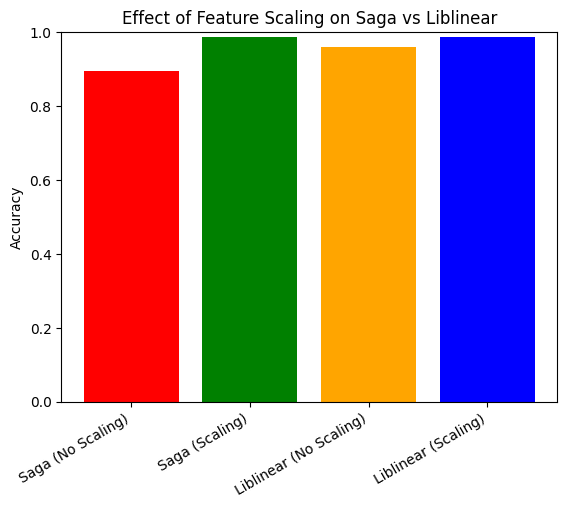

In [ ]:
# Logistic Regression: Saga vs Liblinear, with and without scaling
# Google Colab code

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# 2. Artificially distort feature scales (to exaggerate scaling effects)
X[:, :15] *= 1000   # blow up first 15 features

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- WITHOUT SCALING ---
clf_saga_no = LogisticRegression(solver="saga", penalty="l2", max_iter=2000, random_state=42)
clf_saga_no.fit(X_train, y_train)
acc_saga_no = accuracy_score(y_test, clf_saga_no.predict(X_test))

clf_lib_no = LogisticRegression(solver="liblinear", penalty="l2", max_iter=2000, random_state=42)
clf_lib_no.fit(X_train, y_train)
acc_lib_no = accuracy_score(y_test, clf_lib_no.predict(X_test))

# --- WITH SCALING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf_saga_sc = LogisticRegression(solver="saga", penalty="l2", max_iter=2000, random_state=42)
clf_saga_sc.fit(X_train_scaled, y_train)
acc_saga_sc = accuracy_score(y_test, clf_saga_sc.predict(X_test_scaled))

clf_lib_sc = LogisticRegression(solver="liblinear", penalty="l2", max_iter=2000, random_state=42)
clf_lib_sc.fit(X_train_scaled, y_train)
acc_lib_sc = accuracy_score(y_test, clf_lib_sc.predict(X_test_scaled))

# --- Print results ---
print("Saga (no scaling):       ", acc_saga_no)
print("Saga (with scaling):     ", acc_saga_sc)
print("Liblinear (no scaling):  ", acc_lib_no)
print("Liblinear (with scaling):", acc_lib_sc)

# --- Plot results ---
labels = ["Saga (No Scaling)", "Saga (Scaling)", "Liblinear (No Scaling)", "Liblinear (Scaling)"]
accuracies = [acc_saga_no, acc_saga_sc, acc_lib_no, acc_lib_sc]
colors = ["red", "green", "orange", "blue"]

plt.bar(labels, accuracies, color=colors)
plt.ylabel("Accuracy")
plt.title("Effect of Feature Scaling on Saga vs Liblinear")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.show()




3.   Logistic regression First/Second-Order Methods - Task 2


*    Updateing the weights with batch Gradient descent







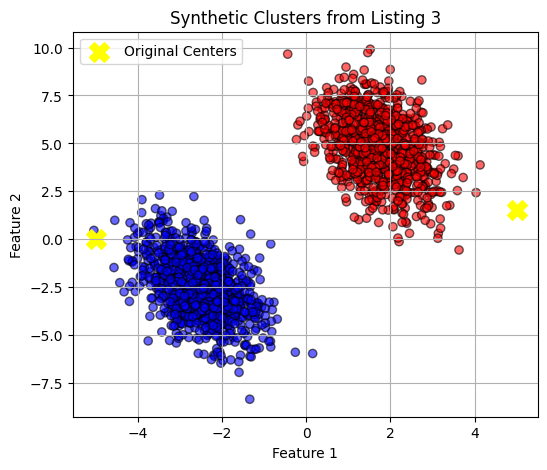

Iteration |   w_0 (intercept)   |     w_1     |     w_2     |   Loss
-----------------------------------------------------------------------
        1 |          0.000000 |   0.105857 |   0.182037 | 0.693147
        2 |         -0.003479 |   0.170585 |   0.277331 | 0.355290
        3 |         -0.007518 |   0.218052 |   0.340134 | 0.244652
        4 |         -0.011498 |   0.256169 |   0.386914 | 0.190069
        5 |         -0.015284 |   0.288320 |   0.424168 | 0.156979
        6 |         -0.018853 |   0.316282 |   0.455106 | 0.134525
        7 |         -0.022212 |   0.341118 |   0.481544 | 0.118171
        8 |         -0.025380 |   0.363520 |   0.504614 | 0.105666
        9 |         -0.028375 |   0.383963 |   0.525067 | 0.095758
       10 |         -0.031214 |   0.402792 |   0.543429 | 0.087693
       11 |         -0.033912 |   0.420265 |   0.560082 | 0.080986
       12 |         -0.036483 |   0.436580 |   0.575311 | 0.075312
       13 |         -0.038940 |   0.451894 |   0.589337

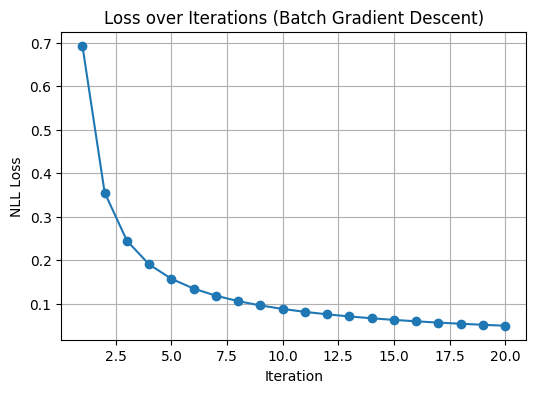

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# ---------------------------
# Generate synthetic data
# ---------------------------
np.random.seed(0)
centers = [[-5, 0], [5, 1.5]]
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = [[0.5, 0.5], [-0.5, 1.5]]
X = np.dot(X, transformation)

# ---------------------------
# Plot the clusters
# ---------------------------
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.6, edgecolors='k')
plt.scatter([-5, 5], [0, 1.5], c='yellow', marker='X', s=200, label='Original Centers')
plt.title("Synthetic Clusters from Listing 3")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Logistic Regression with Batch Gradient Descent
# ---------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Add bias term to X
X_bias = np.c_[np.ones(X.shape[0]), X]
N, d = X_bias.shape

# Initialize weights
w = np.zeros(d)

alpha = 0.1
losses = []

print("Iteration |   w_0 (intercept)   |     w_1     |     w_2     |   Loss")
print("-----------------------------------------------------------------------")

for t in range(20):
    # Predictions
    y_pred = sigmoid(X_bias @ w)

    # Gradient
    grad = (1/N) * (X_bias.T @ (y_pred - y))

    # Update
    w = w - alpha * grad

    # Compute loss (NLL)
    loss = -(1/N) * np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
    losses.append(loss)

    # Print iteration details
    print(f"{t+1:9d} | {w[0]:17.6f} | {w[1]:10.6f} | {w[2]:10.6f} | {loss:.6f}")

# ---------------------------
# Plot the loss curve
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1,21), losses, marker='o')
plt.xlabel("Iteration")
plt.ylabel("NLL Loss")
plt.title("Loss over Iterations (Batch Gradient Descent)")
plt.grid(True)
plt.show()





3.   Logistic regression First/Second-Order Methods - Task 5


*   Updateing the weights with Newton's Method and comparision of convergance between Newton's Method and Batch Gradient Descent Method









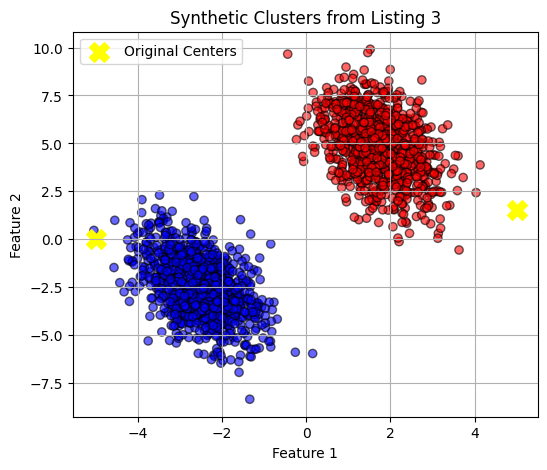

=== Batch Gradient Descent ===
Iteration |   w_0 (intercept)   |     w_1     |     w_2     |   Loss
----------------------------------------------------------------------
        1 |          0.000000 |   0.105857 |   0.182037 | 0.693147
        2 |         -0.003479 |   0.170585 |   0.277331 | 0.355290
        3 |         -0.007518 |   0.218052 |   0.340134 | 0.244652
        4 |         -0.011498 |   0.256169 |   0.386914 | 0.190069
        5 |         -0.015284 |   0.288320 |   0.424168 | 0.156979
        6 |         -0.018853 |   0.316282 |   0.455106 | 0.134525
        7 |         -0.022212 |   0.341118 |   0.481544 | 0.118171
        8 |         -0.025380 |   0.363520 |   0.504614 | 0.105666
        9 |         -0.028375 |   0.383963 |   0.525067 | 0.095758
       10 |         -0.031214 |   0.402792 |   0.543429 | 0.087693
       11 |         -0.033912 |   0.420265 |   0.560082 | 0.080986
       12 |         -0.036483 |   0.436580 |   0.575311 | 0.075312
       13 |         -0.03

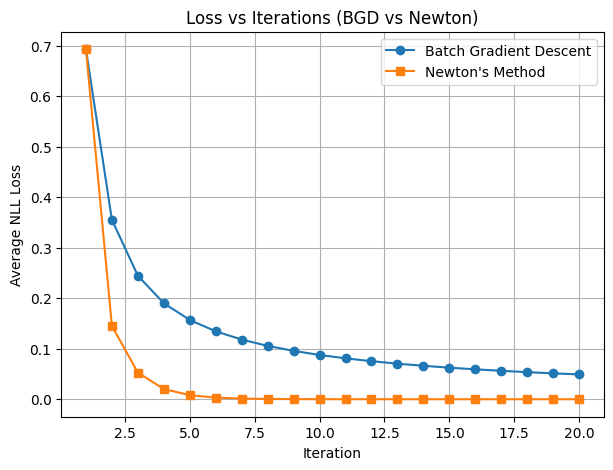

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# ---------------------------
# Generate synthetic data (original centers)
# ---------------------------
np.random.seed(0)
centers = [[-5, 0], [5, 1.5]]
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = [[0.5, 0.5], [-0.5, 1.5]]
X = np.dot(X, transformation)

# ---------------------------
# Plot the clusters
# ---------------------------
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.6, edgecolors='k')
plt.scatter([-5, 5], [0, 1.5], c='yellow', marker='X', s=200, label='Original Centers')
plt.title("Synthetic Clusters from Listing 3")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Helper functions
# ---------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def nll_loss(y_true, mu):
    eps = 1e-12
    mu = np.clip(mu, eps, 1 - eps)   # avoid log(0)
    return -(1/len(y_true)) * np.sum(y_true*np.log(mu) + (1-y_true)*np.log(1-mu))

# Add bias term
X_bias = np.c_[np.ones(X.shape[0]), X]
N, d = X_bias.shape

# =====================================================
# Batch Gradient Descent (20 iterations)
# =====================================================
w_gd = np.zeros(d)
alpha = 0.1
losses_gd = []

print("=== Batch Gradient Descent ===")
print("Iteration |   w_0 (intercept)   |     w_1     |     w_2     |   Loss")
print("----------------------------------------------------------------------")

for t in range(20):
    mu = sigmoid(X_bias @ w_gd)
    grad = (1/N) * (X_bias.T @ (mu - y))
    w_gd = w_gd - alpha * grad
    loss = nll_loss(y, mu)
    losses_gd.append(loss)
    print(f"{t+1:9d} | {w_gd[0]:17.6f} | {w_gd[1]:10.6f} | {w_gd[2]:10.6f} | {loss:.6f}")

# =====================================================
# Newton's Method (20 iterations)
# =====================================================
w_newton = np.zeros(d)
losses_newton = []

print("\n=== Newton's Method ===")
print("Iteration |   w_0 (intercept)   |     w_1     |     w_2     |   Loss")
print("----------------------------------------------------------------------")

for t in range(20):
    mu = sigmoid(X_bias @ w_newton)
    grad = (1/N) * (X_bias.T @ (mu - y))
    S = mu * (1 - mu)
    XS = X_bias * S[:, np.newaxis]
    H = (1/N) * (X_bias.T @ XS)

    # Add ridge for numerical stability
    ridge = 1e-8 * np.eye(d)
    step = np.linalg.solve(H + ridge, grad)
    w_newton = w_newton - step

    loss = nll_loss(y, mu)
    losses_newton.append(loss)
    print(f"{t+1:9d} | {w_newton[0]:17.6f} | {w_newton[1]:10.6f} | {w_newton[2]:10.6f} | {loss:.6f}")

# =====================================================
# Plot loss comparison
# =====================================================
plt.figure(figsize=(7,5))
plt.plot(range(1,21), losses_gd, marker='o', label="Batch Gradient Descent")
plt.plot(range(1,21), losses_newton, marker='s', label="Newton's Method")
plt.xlabel("Iteration")
plt.ylabel("Average NLL Loss")
plt.title("Loss vs Iterations (BGD vs Newton)")
plt.legend()
plt.grid(True)
plt.show()




3.   Logistic regression First/Second-Order Methods - Task 7


*   Updateing the weights with batch Gradient descent after the centers of the two clusters have been changed to a closer gap


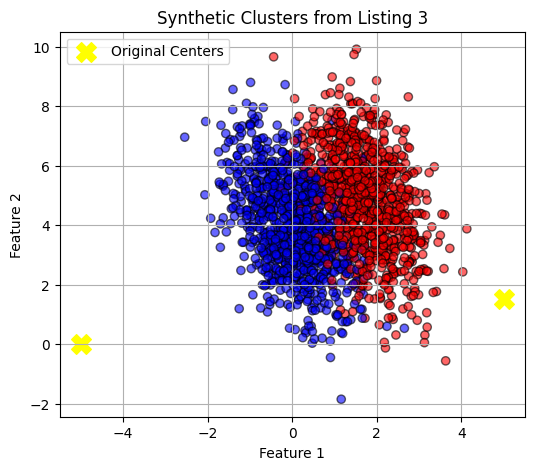

Iteration |   w_0 (intercept)   |     w_1     |     w_2     |   Loss
-----------------------------------------------------------------------
        1 |          0.000000 |   0.043357 |   0.019537 | 0.693147
        2 |         -0.003083 |   0.082780 |   0.024296 | 0.672831
        3 |         -0.007446 |   0.119901 |   0.023224 | 0.657542
        4 |         -0.012362 |   0.155405 |   0.019912 | 0.643837
        5 |         -0.017533 |   0.189596 |   0.015814 | 0.631094
        6 |         -0.022836 |   0.222624 |   0.011520 | 0.619160
        7 |         -0.028218 |   0.254580 |   0.007267 | 0.607962
        8 |         -0.033656 |   0.285525 |   0.003146 | 0.597443
        9 |         -0.039138 |   0.315511 |  -0.000811 | 0.587553
       10 |         -0.044659 |   0.344582 |  -0.004597 | 0.578244
       11 |         -0.050215 |   0.372782 |  -0.008216 | 0.569473
       12 |         -0.055803 |   0.400149 |  -0.011672 | 0.561201
       13 |         -0.061421 |   0.426721 |  -0.014975

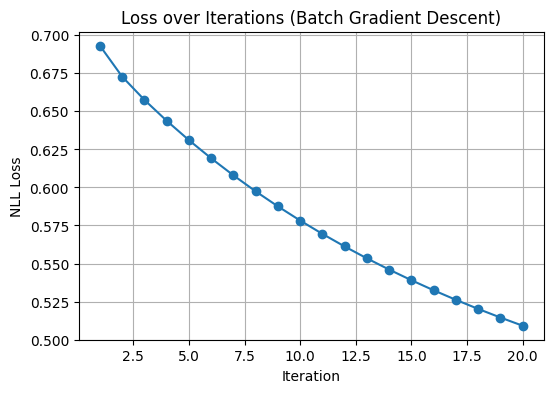

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# ---------------------------
# Generate synthetic data
# ---------------------------
np.random.seed(0)
centers = [[2,2], [5, 1.5]]
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = [[0.5, 0.5], [-0.5, 1.5]]
X = np.dot(X, transformation)

# ---------------------------
# Plot the clusters
# ---------------------------
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.6, edgecolors='k')
plt.scatter([-5, 5], [0, 1.5], c='yellow', marker='X', s=200, label='Original Centers')
plt.title("Synthetic Clusters from Listing 3")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Logistic Regression with Batch Gradient Descent
# ---------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Add bias term to X
X_bias = np.c_[np.ones(X.shape[0]), X]
N, d = X_bias.shape

# Initialize weights
w = np.zeros(d)

alpha = 0.1
losses = []

print("Iteration |   w_0 (intercept)   |     w_1     |     w_2     |   Loss")
print("-----------------------------------------------------------------------")

for t in range(20):
    # Predictions
    y_pred = sigmoid(X_bias @ w)

    # Gradient
    grad = (1/N) * (X_bias.T @ (y_pred - y))

    # Update
    w = w - alpha * grad

    # Compute loss (NLL)
    loss = -(1/N) * np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
    losses.append(loss)

    # Print iteration details with named weights
    print(f"{t+1:9d} | {w[0]:17.6f} | {w[1]:10.6f} | {w[2]:10.6f} | {loss:.6f}")

# ---------------------------
# Plot the loss curve
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1,21), losses, marker='o')
plt.xlabel("Iteration")
plt.ylabel("NLL Loss")
plt.title("Loss over Iterations (Batch Gradient Descent)")
plt.grid(True)
plt.show()



3.   Logistic regression First/Second-Order Methods - Task 7


*   Comparision of convergance of batch Gradient Descent method after 20 iterations with varying gap between centers




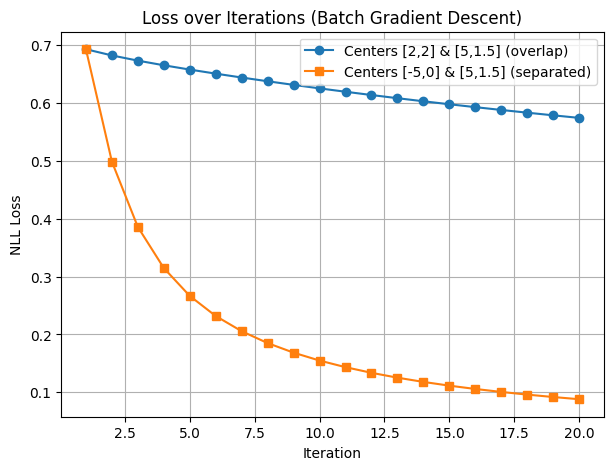

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def run_bgd(centers, alpha=0.05, iters=20):
    """Generate data, run Batch Gradient Descent, return losses."""
    np.random.seed(0)
    X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
    transformation = [[0.5, 0.5], [-0.5, 1.5]]
    X = np.dot(X, transformation)

    # Add bias term
    X_bias = np.c_[np.ones(X.shape[0]), X]
    N, d = X_bias.shape
    w = np.zeros(d)

    losses = []
    for t in range(iters):
        y_pred = sigmoid(X_bias @ w)
        y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
        grad = (1/N) * (X_bias.T @ (y_pred - y))
        w = w - alpha * grad
        loss = -(1/N) * np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
        losses.append(loss)
    return losses

# ---------------------------
# Run BGD for both center configs
# ---------------------------
losses_new = run_bgd([[2, 2], [5, 1.5]])        # new centers
losses_orig = run_bgd([[-5, 0], [5, 1.5]])      # original centers

# ---------------------------
# Plot comparison
# ---------------------------
plt.figure(figsize=(7,5))
plt.plot(range(1,21), losses_new, marker='o', label="Centers [2,2] & [5,1.5] (overlap)")
plt.plot(range(1,21), losses_orig, marker='s', label="Centers [-5,0] & [5,1.5] (separated)")
plt.xlabel("Iteration")
plt.ylabel("NLL Loss")
plt.title("Loss over Iterations (Batch Gradient Descent)")
plt.legend()
plt.grid(True)
plt.show()
